In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# initialize the spark environment
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

In [4]:
# connect to S3 and retrieve data
role = get_execution_role()
bucket='odl-spark19spds6003-001'
# this is census data for counties in US
data_key = 'dr2de/census_county.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
5,1011,Alabama,Bullock,10678,5660,5018,4.4,22.2,70.7,1.2,...,5.0,1.7,2.8,27.5,3865,79.5,15.1,5.4,0.0,18.0
6,1013,Alabama,Butler,20354,9502,10852,1.2,53.3,43.8,0.1,...,0.8,0.6,1.7,24.6,7813,77.4,16.2,6.2,0.2,10.9
7,1015,Alabama,Calhoun,116648,56274,60374,3.5,73.0,20.3,0.2,...,1.2,1.2,2.7,24.1,47401,74.1,20.8,5.0,0.1,12.3
8,1017,Alabama,Chambers,34079,16258,17821,0.4,57.3,40.3,0.2,...,0.3,0.4,2.1,25.1,13689,85.1,12.1,2.8,0.0,8.9
9,1019,Alabama,Cherokee,26008,12975,13033,1.5,91.7,4.8,0.6,...,0.6,0.7,2.5,27.4,10155,73.1,18.5,7.9,0.5,7.9


In [5]:
# 
df = sqlc.createDataFrame(pd.read_csv(data_location))
df

DataFrame[CensusId: bigint, State: string, County: string, TotalPop: bigint, Men: bigint, Women: bigint, Hispanic: double, White: double, Black: double, Native: double, Asian: double, Pacific: double, Citizen: bigint, Income: double, IncomeErr: double, IncomePerCap: bigint, IncomePerCapErr: bigint, Poverty: double, ChildPoverty: double, Professional: double, Service: double, Office: double, Construction: double, Production: double, Drive: double, Carpool: double, Transit: double, Walk: double, OtherTransp: double, WorkAtHome: double, MeanCommute: double, Employed: bigint, PrivateWork: double, PublicWork: double, SelfEmployed: double, FamilyWork: double, Unemployment: double]

In [10]:
# convert data to parquet 
parquetPath = '/home/ec2-user/SageMaker/dr2de/census_parquet_data'
df.write.parquet(parquetPath)

# prep list of files to transfer to s3
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "dr2de/pqt/"+f)

copying /home/ec2-user/SageMaker/dr2de/census_parquet_data/part-00000-46e962a0-b77a-497e-9122-d04da77d42dc-c000.snappy.parquet to sample_data/part-00000-46e962a0-b77a-497e-9122-d04da77d42dc-c000.snappy.parquet
copying /home/ec2-user/SageMaker/dr2de/census_parquet_data/.part-00000-46e962a0-b77a-497e-9122-d04da77d42dc-c000.snappy.parquet.crc to sample_data/.part-00000-46e962a0-b77a-497e-9122-d04da77d42dc-c000.snappy.parquet.crc
copying /home/ec2-user/SageMaker/dr2de/census_parquet_data/._SUCCESS.crc to sample_data/._SUCCESS.crc
copying /home/ec2-user/SageMaker/dr2de/census_parquet_data/_SUCCESS to sample_data/_SUCCESS


In [7]:
# write to spark dataframe from parquet 
df = sqlc.read.parquet(parquetPath)
df

DataFrame[CensusId: bigint, State: string, County: string, TotalPop: bigint, Men: bigint, Women: bigint, Hispanic: double, White: double, Black: double, Native: double, Asian: double, Pacific: double, Citizen: bigint, Income: double, IncomeErr: double, IncomePerCap: bigint, IncomePerCapErr: bigint, Poverty: double, ChildPoverty: double, Professional: double, Service: double, Office: double, Construction: double, Production: double, Drive: double, Carpool: double, Transit: double, Walk: double, OtherTransp: double, WorkAtHome: double, MeanCommute: double, Employed: bigint, PrivateWork: double, PublicWork: double, SelfEmployed: double, FamilyWork: double, Unemployment: double]

### MLib analysis

In [8]:
df.printSchema()

root
 |-- CensusId: long (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- TotalPop: long (nullable = true)
 |-- Men: long (nullable = true)
 |-- Women: long (nullable = true)
 |-- Hispanic: double (nullable = true)
 |-- White: double (nullable = true)
 |-- Black: double (nullable = true)
 |-- Native: double (nullable = true)
 |-- Asian: double (nullable = true)
 |-- Pacific: double (nullable = true)
 |-- Citizen: long (nullable = true)
 |-- Income: double (nullable = true)
 |-- IncomeErr: double (nullable = true)
 |-- IncomePerCap: long (nullable = true)
 |-- IncomePerCapErr: long (nullable = true)
 |-- Poverty: double (nullable = true)
 |-- ChildPoverty: double (nullable = true)
 |-- Professional: double (nullable = true)
 |-- Service: double (nullable = true)
 |-- Office: double (nullable = true)
 |-- Construction: double (nullable = true)
 |-- Production: double (nullable = true)
 |-- Drive: double (nullable = true)
 |-- Carpool: doub

In [9]:
# look at some correlations (unemployment is the target variable)
print("Pearson's r(Unemployment,IncomePerCap) = {}".format(df.corr("Unemployment", "IncomePerCap")))
print("Pearson's r(Unemployment,Poverty) = {}".format(df.corr("Unemployment", "Poverty")))
print("Pearson's r(Unemployment,Service) = {}".format(df.corr("Unemployment", "Service")))
print("Pearson's r(Unemployment,Professional) = {}".format(df.corr("Unemployment", "Professional")))
print("Pearson's r(Unemployment,MeanCommute) = {}".format(df.corr("Unemployment", "MeanCommute")))
print("Pearson's r(Unemployment,PublicWork) = {}".format(df.corr("Unemployment", "PublicWork")))


Pearson's r(Unemployment,IncomePerCap) = -0.5475960044237942
Pearson's r(Unemployment,Poverty) = 0.7123438646244138
Pearson's r(Unemployment,Service) = 0.36456374594756263
Pearson's r(Unemployment,Professional) = -0.30064794791821414
Pearson's r(Unemployment,MeanCommute) = 0.2937249072896706
Pearson's r(Unemployment,PublicWork) = 0.30601503694537463


In [10]:
# create train/test sets
seed = 10
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 2547, test set N = 673


In [11]:
from pyspark.ml.linalg import Vectors, VectorUDT 

In [13]:
# make udf
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("Unemployment", "oneElementVec(Poverty) as Poverty")
testDF = testDF.selectExpr("Unemployment", "oneElementVec(Poverty) as Poverty")

print(testDF.orderBy(testDF.Unemployment.desc()).limit(5))

DataFrame[Unemployment: double, Poverty: vector]


In [14]:

# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("Unemployment", "label").withColumnRenamed("Poverty", "features")
testDF = testDF.withColumnRenamed("Unemployment", "label").withColumnRenamed("Poverty", "features")

In [15]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

# train linear regression model
lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [16]:
type(lrModel)


pyspark.ml.regression.LinearRegressionModel

In [17]:
# get predictions on test data 
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=31.7, features=DenseVector([57.8]), prediction=22.00332688570559), Row(label=28.7, features=DenseVector([53.3]), prediction=20.45360213885853), Row(label=27.5, features=DenseVector([59.1]), prediction=22.451025145905852), Row(label=27.4, features=DenseVector([39.5]), prediction=15.701112915194205), Row(label=27.1, features=DenseVector([51.7]), prediction=19.90258889553513)]


### Model Evaluation

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

2.8217942611677493

In [20]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.5417121927463047

### Visualization

In [24]:
type(predictionsAndLabelsDF)

pyspark.sql.dataframe.DataFrame

In [47]:
# convert dataframe to pandas and plot
pdf1 = predictionsAndLabelsDF.toPandas()

In [44]:
results = pd.DataFrame({'obs': range(0,673),
                        'resids': pdf1.label - pdf1.prediction})

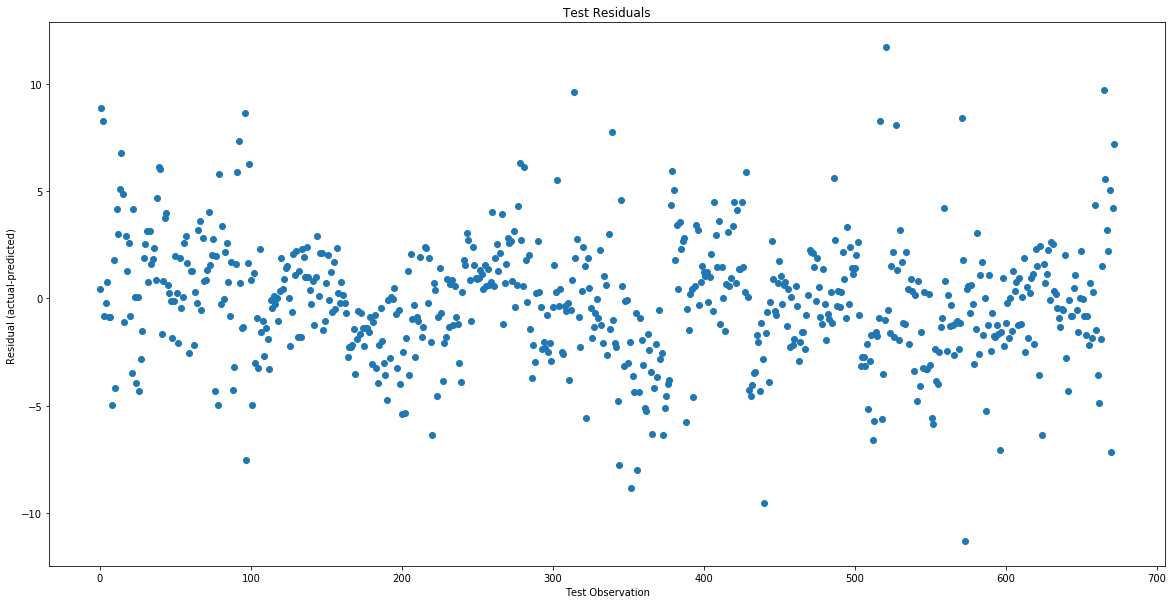

In [46]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(results.obs,results.resids)
plt.title("Test Residuals")
plt.xlabel("Test Observation")
plt.ylabel("Residual (actual-predicted) ")
plt.show()